<a href="https://colab.research.google.com/github/csipapicsa/fyp2021p03q10/blob/main/FYP_project_3_evaluation_keratosi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get some images and import packages

In [1]:
if True:      #A weird trick needed for Google Colab
  # Clone repository with example images 
  !rm -rf fyp2021p3
  !git clone https://github.com/vcheplygina/fyp2021p3.git


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Cloning into 'fyp2021p3'...
remote: Enumerating objects: 387, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 387 (delta 6), reused 2 (delta 0), pack-reused 374
Receiving objects: 100% (387/387), 855.59 MiB | 36.04 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Checking out files: 100% (366/366), done.


# Load data

In [9]:
# Load features and labels

file_data = 'fyp2021p3/data/example_ground_truth.csv'
file_features = 'fyp2021p3/features/features.csv'

df = pd.read_csv(file_data)
features = pd.read_csv(file_features)


# Combine variables we want in one place
df = df.drop(['image_id','melanoma'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

print(df.head())


   seborrheic_keratosis      area  perimeter
0                   0.0  216160.0     2013.0
1                   0.0  130493.0     1372.0
2                   0.0  205116.0     1720.0
3                   0.0  161705.0     1344.0
4                   0.0  317040.0     2063.0


# Plots of features

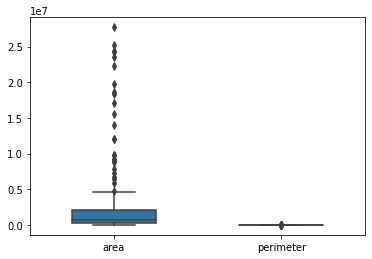

In [10]:
# Plots of features

import seaborn as sns

df1 = df[['area','perimeter']]
sns.boxplot(data=df1, width=0.5)



3.552713678800501e-17
1.0


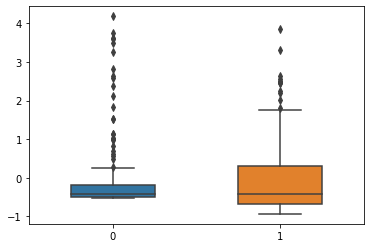

In [11]:
# Let's scale the features
from sklearn import preprocessing

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(df1)

#Apply to data itself
df2 = scaler.transform(df1)

print(df2.mean()) #small number close to 0, round of error
print(df2.var())  #equal to 1 
sns.boxplot(data=df2, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0

In [ ]:
# df_max = df1 / df1.max()
# [0, 0.1, 0.2, ..... 0.8, 10000]
# [0, 0, 0,....... 1]

,area,perimeter
0,-0.493031,-0.674136
1,-0.507605,-0.795608
2,-0.494909,-0.729661
3,-0.502295,-0.800914
4,-0.475868,-0.664661
...,...,...
145,1.126062,1.554817
146,1.520243,2.642952
147,0.976942,1.562018
148,0.993111,1.548563


,seborrheic_keratosis,area,perimeter
0,0.0,216160.0,2013.0
1,0.0,130493.0,1372.0
2,0.0,205116.0,1720.0
3,0.0,161705.0,1344.0
4,0.0,317040.0,2063.0
...,...,...,...
145,0.0,9732988.0,13775.0
146,0.0,12049938.0,19517.0
147,0.0,8856478.0,13813.0
148,0.0,8951522.0,13742.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


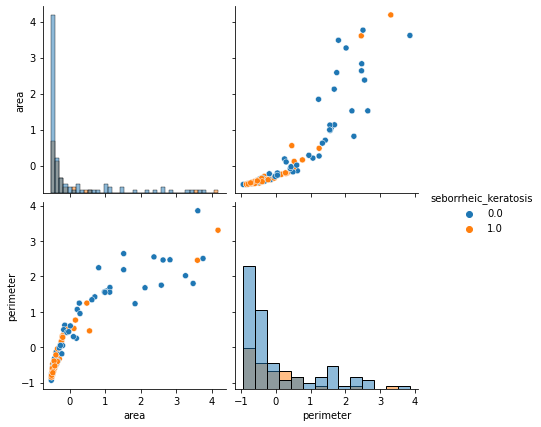

In [12]:
#print(df2.dtype) #scaler lost df information :(
df2 = pd.DataFrame(df2,columns=['area','perimeter'])
display(df2)
display(df)

# Look at values per class
df2['seborrheic_keratosis'] = df['seborrheic_keratosis']
sns.pairplot(df2, hue="seborrheic_keratosis", size=3,diag_kind="hist")

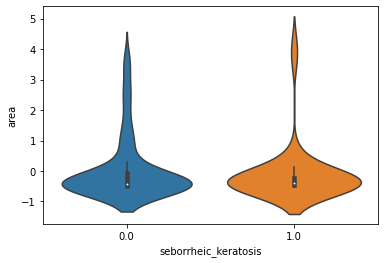

In [13]:
ax = sns.violinplot(x="seborrheic_keratosis", y="area", data=df2,size=8)

# Feature selection

In [15]:
# Split the data before feature selection
from sklearn.model_selection import train_test_split

# Some noisy data not correlated
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((df2[['area', 'perimeter']], noise))
y = df2['seborrheic_keratosis']

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)


<BarContainer object of 22 artists>

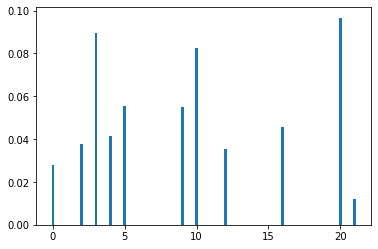

In [16]:
# Univariate feature selection with mutual information for feature scoring
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

plt.bar(np.arange(0,22), scores, width=.2,
        label=r'Feature score')

# Train several classifiers

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Select features that had good scores on training set
X_train1 = X_train[:, [0,1]]
X_train2 = selector.transform(X_train)

# Train a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1trained = knn1.fit(X_train2, y_train)

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2trained = knn2.fit(X_train2, y_train)

tree1 = DecisionTreeClassifier() # various hyperparameters
tree1trained = tree1.fit(X_train2, y_train)


# Evaluate classifiers on validation set

In [18]:
#Select the same features as before
X_val1 = X_val[:, [0,1]]
X_val2 = selector.transform(X_val)

y_val_knn1 = knn1trained.predict(X_val2)
y_val_knn2 = knn2trained.predict(X_val2)

# Simple accuracy
print(np.sum(y_val_knn1 == y_val) / np.size(y_val) * 100)
print(np.sum(y_val_knn2 == y_val) / np.size(y_val) * 100)

64.28571428571429
71.42857142857143


In [19]:
from sklearn.metrics import accuracy_score

acc_knn1 = accuracy_score(y_val, y_val_knn1)
acc_knn2 = accuracy_score(y_val, y_val_knn2)

print(acc_knn1)
print(acc_knn2)

0.6428571428571429
0.7142857142857143


In [20]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_val, y_val_knn1)
auc2 = roc_auc_score(y_val, y_val_knn2)

print(auc1)
print(auc2)

0.4875
0.575


In [21]:
# ONLY FOR REPORTING, also evaluate on test set
X_test = X_test[:, [0,1]]

y_test_knn1 = knn2trained.predict(X_test)

acc_test = accuracy_score(y_test, y_test_knn1)
auc_test = roc_auc_score(y_test, y_test_knn1)

print(acc_test)
print(auc_test)

# For small datasets these results will depend on the random seed you chose when splitting, this is why it is good to look at multiple splits/cross-validation

0.7894736842105263
0.744107744107744
